In [1]:
# import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch
import yaml
from einops import rearrange

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom
import mushroom.utils as utils

In [5]:
run_dir = '/data/estorrs/mushroom/data/projects/subclone'
mushroom_dir = os.path.join(run_dir, 'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config.yaml'))
config_fps

['/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT206B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT225C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT226C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT235B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H3/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H4/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT268B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT271B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT339B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT413C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclon

In [6]:
# only relavent for dinglab data since our channel names are all over the place
# will remove for official example
official_to_options = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'Pan-CK (D)', 'PanCK (D)'],
    'E-cadherin': ['E-cadherin'],
    'CD45': ['CD45 (D)', 'CD45', 'CD45-(D)'],
    'CD45RO': ['CD45RO'],
    'CD45RA': ['CD45RA'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4', 'CD4 (D)'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin-(D)', 'Vimentin', 'Vimentin (D)'],
    'SMA': ['SMA-(D)', 'SMA', 'SMA (D)', 'a-SMA (D)'],
    'CD31': ['CD31', 'CD31-(D)', 'CD31 (D)'],
    'CD20': ['CD20-(D)', 'CD20', 'CD20 (D)', 'CD20-Akoya'],
    'CD68': ['CD68', 'CD68 (D)', 'CD68-(D)'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKIT (D)', 'cKit (D)', 'cKit', 'cKIT', 'cKIT-(D)'],
    'MGP': ['MGP', 'MGP (D)', 'MGP-(D)'],
    'CD36': ['CD36-(D)', 'CD36'],
    'PR': ['PR', 'PR-(D)', 'PR (D)'],
    'ER': ['ER', 'ER-(D)', 'ER (D)'],
    'P21': ['P21', 'P21-(D)', 'P21-(D)', 'P21 (D)'],
    'P16': ['P16-(D)'],
    'CK5': ['Keratin 5', 'KRT5'],
    'TFF1': ['TFF1', 'TFF1-(D)', 'TFF1 (D)'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14', 'CK14 (D)'],
    'CK17': ['CK17', 'CK17 (D)', 'CK17-(D)', 'Keratin 17'],
    'CK19': ['CK19', 'CK19 (D)', 'CK19-(D)'],
    'CD11b': ['CD11b', 'CD11b (D)', 'CD11b-(D)'],
    'GATA3': ['GATA3', 'GATA3-(D)', 'GATA3 (D)'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT/tPA (D)'],
    'COX6c': ['COX6c (D)'],
    'Her2': ['Her2', 'Her2 (D)'],
    'Bap1': ['Bap1 (D)'],
    'GLUT1': ['Glut1', 'GLUT1', 'GLUT1-(D)', 'GLUT1 (D)'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN', 'Podoplanin (D)'],
    'CTLA4': ['CTLA4', 'CTLA4 (D)', 'CTLA4-(D)'],
    'SLC39A6': ['SLC39A6'],
    'BCA1': ['BCA1'],
    'BCAL': ['BCAL'],
    'TUBB3': ['TUBB3', 'TUBB3 (D)'],
    'PTPRZ1': ['PTPRZ1', 'PTPRZ1 (D)'],
    'HIF1A': ['HIF1a', 'HIF1a (D)', 'HIF1A'],
    'PAI1': ['PAI1', 'PAI1-(D)'],
    'GFAP': ['GFAP', 'GFAP (D)'],
    'VEGFA': ['VEGFA', 'VEGFA (D)'],
    'IBA1': ['IBA1', 'IBA1 (D)'],
    'OLIG2': ['OLIG2', 'OLIG2 (D)'],
    'FN1': ['FN1', 'FN1 (D)'],
    'a-Amylase': ['a-Amylase'],
    'Hep-Par-1': ['Hep-Par-1 (D)'],
    'Granzyme-B': ['Granzyme B'],
    'TCF-1': ['TCF-1'],
    'CD39': ['CD39'],
    'PD1': ['PD-1'],
    'PDL1': ['PD-L1'],
    'Histone-H3-Pho': ['Histone H3 Pho'],
    'Maspin': ['Maspin'],
    'MMP9': ['MMP9'],
    'CD44': ['CD44'],
    'CD107A': ['CD107a'],
    'FGFR3': ['FGFR3'],
    'CD138': ['CD138'],
    'MLPH': ['MLPH'],
    'P63': ['P63'],
    'GP2': ['GP2'],
    'COX2': ['COX2'],
    'Lyve-1': ['Lyve-1'],
}
channel_mapping = {v:k for k, vs in official_to_options.items() for v in vs}
# channel_mapping = None

In [7]:
visium_config = {
    'dtype': 'multiplex',
#     'sections': config,
    'chkpt_filepath': None,
    'sae_kwargs': {
        'size': 256,
        'patch_size': 32,
        'encoder_dim': 256,
        'kl_scaler': .001,
        'recon_scaler': 1.,
        'neigh_scaler': 2.,
        'codebook_size': 100,
        'decoder_dims': (256, 100, 30,)
    },
    'learner_kwargs': {
        'scale': .1,
        'contrast_pct': None,
#         'pct_expression': .02,
        'batch_size': 64,
        'num_workers': 1,
        'device': 'cpu',
#         'channels': channels,
        'channel_mapping': channel_mapping
    },
    'train_kwargs': {
        'num_iters': 10000,
        'lr': 1e-4,
        'log_every': 10,
        'save_every': 1000,
#         'save_dir': chkpt_dir       
    },
}

In [8]:
config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml'

case = config_fp.split('/')[-2]
out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/testing/mushroom/{case}_vae_vq_codex_cb30/outputs')

config = yaml.safe_load(open(config_fp))

chkpt_dir = os.path.join(out_dir, 'chkpts')
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [9]:
visium_config['sections'] = config
visium_config['train_kwargs']['save_dir'] = chkpt_dir
visium_config['chkpt_filepath'] = os.path.join(chkpt_dir, '2000iter.pt')

In [10]:
mushroom = Mushroom.from_config(visium_config)

INFO:root:using device: cpu
INFO:root:generating inputs for multiplex tissue sections
INFO:root:using 24 channels
INFO:root:4 sections detected: ['s1', 's2', 's4', 's5']
INFO:root:processing sections
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:learner initialized


In [11]:
mushroom.embed_sections()

array([[<Axes: title={'center': 's1'}, ylabel='predicted'>,
        <Axes: title={'center': 's2'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's5'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

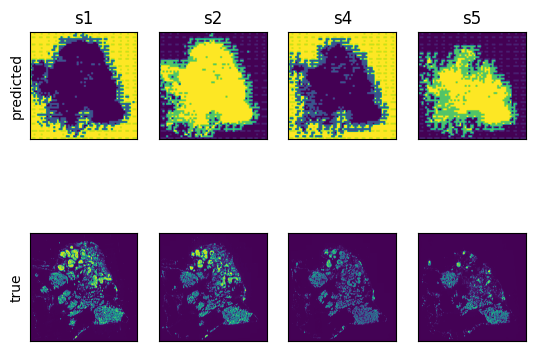

In [12]:
mushroom.display_predicted_pixels(channel='Pan-Cytokeratin')

array([[<Axes: title={'center': 's1'}, ylabel='predicted'>,
        <Axes: title={'center': 's2'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's5'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

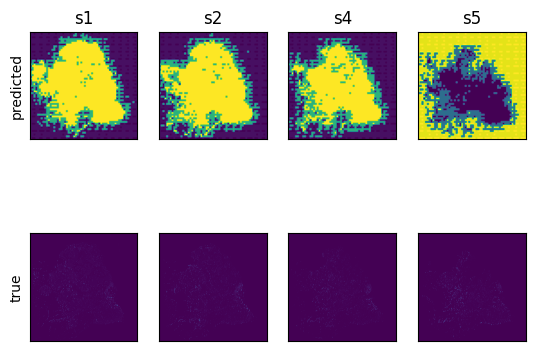

In [13]:
mushroom.display_predicted_pixels(channel='CD31')

array([[<Axes: title={'center': 's1'}, ylabel='predicted'>,
        <Axes: title={'center': 's2'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's5'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

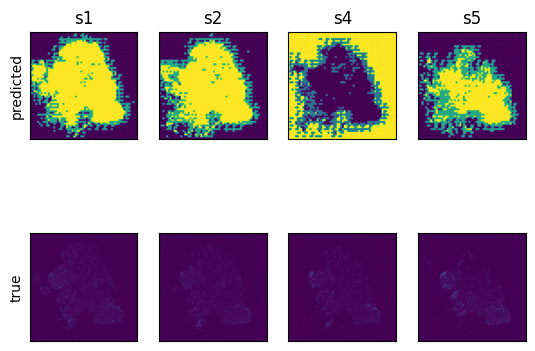

In [14]:
mushroom.display_predicted_pixels(channel='CD45')

array([[<Axes: title={'center': 's1'}, ylabel='predicted'>,
        <Axes: title={'center': 's2'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's5'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

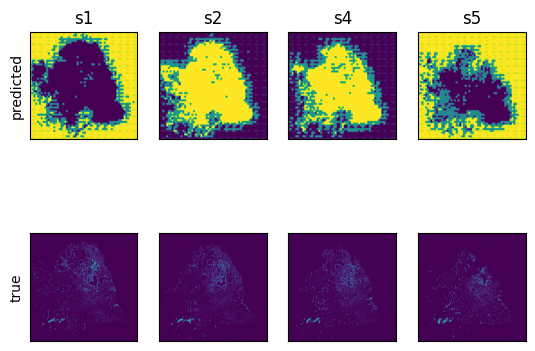

In [15]:
mushroom.display_predicted_pixels(channel='SMA')

In [45]:
# cluster_ids = mushroom.recon_cluster_probs.argmax(dim=1).cpu().detach().numpy()
cluster_ids = mushroom.recon_cluster_ids.cpu().detach().numpy().astype(int)

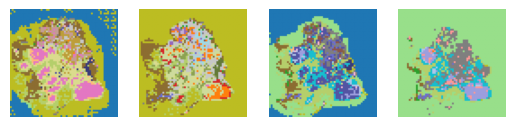

In [46]:
from mushroom.visualization.utils import display_labeled_as_rgb
cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c') + sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
fig, axs = plt.subplots(ncols=len(cluster_ids))
for ax, x in zip(axs, cluster_ids):
    x = display_labeled_as_rgb(x, cmap=cmap)
    ax.imshow(x)
    ax.axis('off')

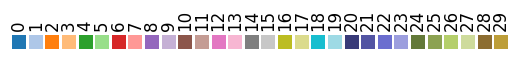

In [47]:
labels = np.unique(cluster_ids)
fig, axs = plt.subplots(ncols=len(labels))
for n, l in enumerate(labels):
    axs[n].imshow(rearrange(np.asarray(cmap[l]), 'n -> 1 1 n'))
    axs[n].axis('off')
    axs[n].set_title(str(l), rotation=90)
    

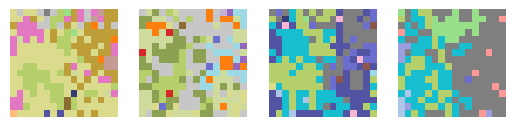

In [48]:
from mushroom.visualization.utils import display_labeled_as_rgb
cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c') + sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
fig, axs = plt.subplots(ncols=len(cluster_ids))
for ax, x in zip(axs, cluster_ids):
    x = display_labeled_as_rgb(x[20:36, 20:36], cmap=cmap)
    ax.imshow(x)
    ax.axis('off')

In [52]:
dists = mushroom.cluster_sims.clone().detach().cpu()

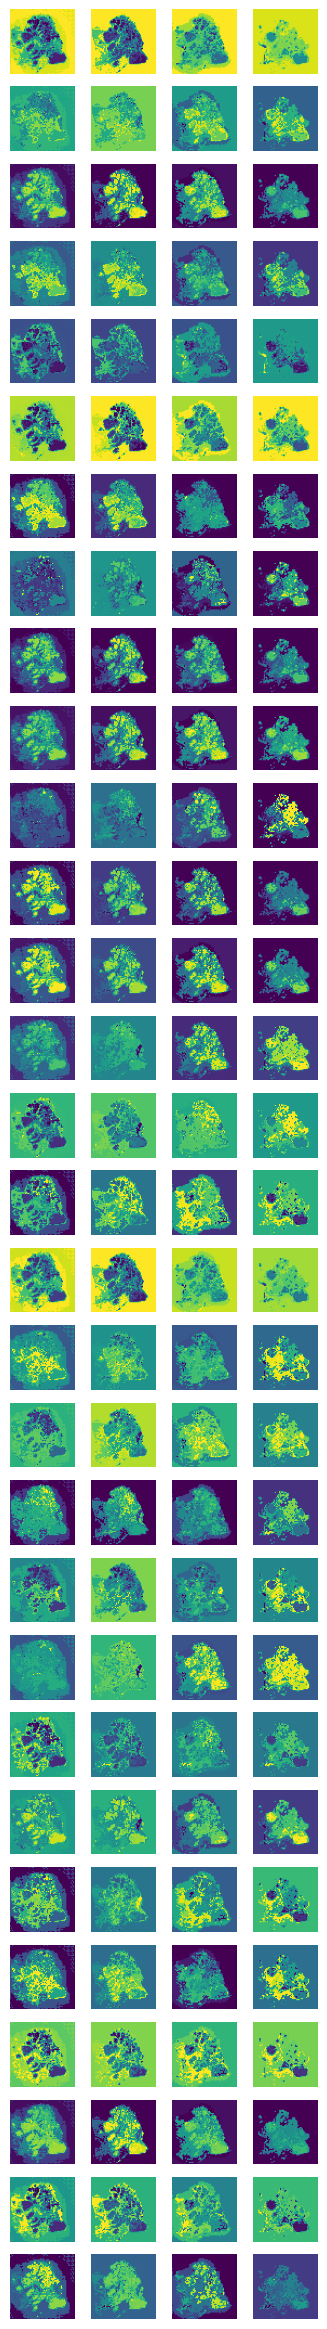

In [53]:
fig, axs = plt.subplots(nrows=dists.shape[1], ncols=dists.shape[0], figsize=(dists.shape[0], dists.shape[1]))
for c in range(dists.shape[0]):
    for r in range(dists.shape[1]):
        ax = axs[r, c]
        ax.imshow(dists[c, r])
        ax.axis('off')
        ax.set_ylabel(r, rotation=90)

In [54]:
exp_df = mushroom.get_cluster_intensities()
exp_df

,Bap1,CD31,CD45,CD68,CD8,CK14,CK19,COX6c,DAPI,ER,...,Her2,Ki67,MGP,PLAT/tPA,PR,Pan-Cytokeratin,Podoplanin,SMA,Vimentin,cKit
0,0.336466,-0.199617,-0.133941,0.021586,-0.029599,0.004471,-0.058759,0.103962,0.002137,-0.143360,...,-0.037553,-0.044115,0.001188,-0.055618,-0.301403,-0.004671,-0.281795,0.006680,-0.123292,-0.035701
1,0.301158,1.000000,0.709775,-0.674706,0.753623,-0.052691,0.059687,0.662895,1.000000,0.039875,...,0.116556,0.053399,0.127909,0.000007,0.061662,0.002884,0.460633,0.505703,-0.464408,-0.046992
2,0.125861,0.234381,0.709244,0.604543,0.049137,0.290155,0.414055,0.457083,0.648076,0.834257,...,0.681508,0.747864,0.268693,0.525569,0.987791,0.693413,0.240367,0.054373,-0.030389,0.339389
3,-0.449173,0.972072,1.000000,0.219609,1.000000,-0.187554,0.103334,-1.091094,0.120599,0.484608,...,0.106551,0.055939,0.097056,0.156173,0.183322,0.067891,0.435645,-0.260869,0.596830,0.010059
4,0.012568,-0.314334,0.045476,0.023617,0.274935,-0.062267,-0.015288,0.190744,-0.032199,0.002330,...,0.002095,-0.017399,0.145261,-0.009960,0.179762,0.080299,-0.849717,0.052859,0.334587,0.085741
5,-0.066942,-0.160044,-0.202136,0.059520,-0.047143,-0.007896,0.008277,-0.286177,-0.178795,-0.115325,...,-0.001686,-0.016240,-0.074441,-0.047339,0.026153,-0.052109,-1.037266,-0.097867,0.636682,0.035163
6,-0.039841,0.686915,0.951179,0.165154,1.000000,0.006526,0.043923,0.611253,1.000000,0.755118,...,0.216152,0.301730,0.027217,0.279823,0.323442,0.190848,0.372827,0.132794,0.744744,-0.017260
7,1.000000,0.120329,0.311216,0.983457,-0.058877,0.982183,1.000000,0.994949,0.408780,-0.089283,...,0.666164,0.693431,0.995475,0.981076,0.971048,0.786847,-4.745936,0.377384,-1.172453,0.985411
8,0.505476,0.428699,1.000000,1.000000,-0.172007,1.000000,0.614052,1.000000,0.814367,1.000000,...,1.000000,1.000000,1.000000,0.982754,0.933826,1.000000,1.000000,0.231713,-0.273062,1.000000
9,-0.083126,0.079311,0.299887,0.279901,-0.085960,0.185296,0.168272,0.150286,0.239067,0.307956,...,0.312380,0.326767,0.111278,0.313207,0.367385,0.261020,0.134056,0.078942,0.060227,0.125237


array([[<Axes: ylabel='0.05'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.07'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.08'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.10'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.12'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.13'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.15'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.17'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.18'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.20'>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

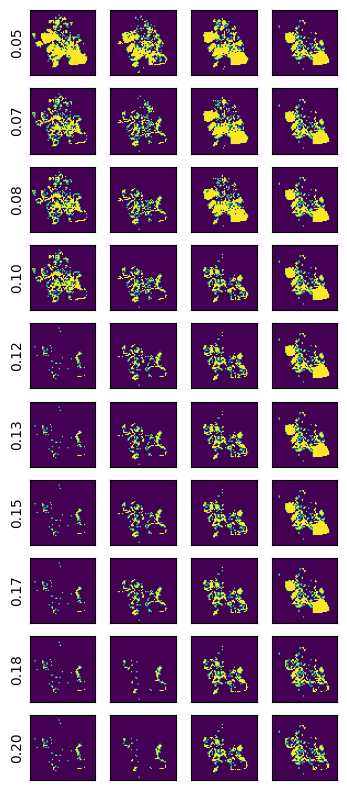

In [55]:
cuts = np.linspace(.05, .2, 10)
utils.display_thresholds(cuts, cluster_ids, exp_df, 'HLA-DR')

In [488]:
distances.shape

torch.Size([4, 100, 60, 60])

In [489]:
codes = mushroom.learner.sae.vq.codebook.detach().cpu().numpy()
codes.shape

(100, 256)

In [490]:
mat = F.cosine_similarity(
    mushroom.learner.sae.vq.codebook.unsqueeze(dim=-1),
    mushroom.learner.sae.vq.codebook.t()
).numpy()
mat.shape

(100, 100)

In [570]:
# cluster based on cos emb

from sklearn.cluster import AgglomerativeClustering
dist = 2.
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=dist).fit(
    mat
)
# clustering = AgglomerativeClustering(n_clusters=10, distance_threshold=None).fit(exp.values)
cluster_to_label = {c:l for c, l in zip(range(mat.shape[0]), clustering.labels_)}
neigh_ids = np.vectorize(cluster_to_label.get)(cluster_ids)
len(np.unique(neigh_ids))

18

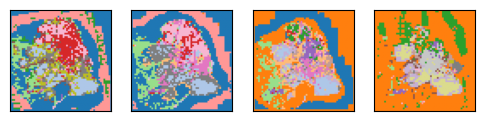

In [571]:
fig, axs = plt.subplots(ncols=neigh_ids.shape[0], figsize=(6, 4))
for i, labeled in enumerate(neigh_ids):
    axs[i].imshow(display_labeled_as_rgb(labeled, cmap=cmap))
    axs[i].set_xticks([])
    axs[i].set_yticks([])

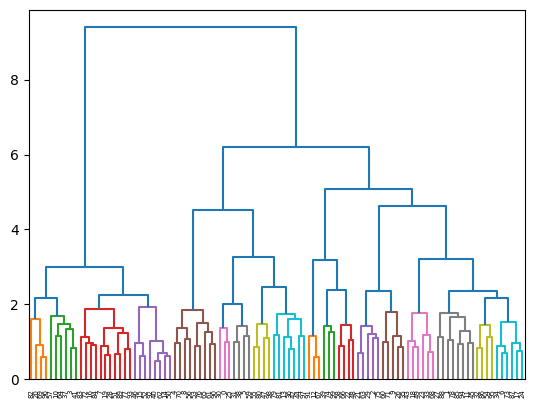

In [572]:
import scipy.cluster.hierarchy as shc
links = shc.linkage(mat, method ='ward')
dendrogram = shc.dendrogram((links), color_threshold=dist, labels=list(range(mat.shape[0])))

In [522]:
recon_exp = mushroom.recon_imgs.numpy()
recon_exp.shape

(4, 24, 60, 60)

In [525]:
scalers = np.amax(recon_exp, axis=(2, 3))
scalers.shape

(4, 24)

In [528]:
scaled_exp = recon_exp / rearrange(scalers, 'n c -> n c 1 1')
scaled_exp.shape

(4, 24, 60, 60)

In [530]:
scaled_exp[0, 0].max()
scaled_exp[1, 0].max()

1.0

In [520]:
i = mushroom.learner.channels.index('CD45')
slides = exp[:, i]
for x, cids in zip(slides, cluster_ids):
    mask = cids==i
    delta = x[mask].mean() - x[~mask].mean()
    

/tmp/ipykernel_563483/2274795491.py:5: RuntimeWarning: Mean of empty slice.
  delta = x[mask].mean() - x[~mask].mean()
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [516]:
np.amax(exp, axis=(1,2,3))

array([255., 255., 255., 255.], dtype=float32)

In [506]:
exp.shape

(4, 24, 60, 60)

In [536]:
data = []
for i, channel in enumerate(mushroom.learner.channels):
    row = []
    for j in np.unique(cluster_ids):
#         row.append(scaled_exp[:, i][cluster_ids==j].mean())
        xs = scaled_exp[:, i][cluster_ids==j].flatten()
        row.append(xs[len(xs) // 2])
    data.append(row)
exp_df = pd.DataFrame(data=data, columns=np.unique(cluster_ids), index=mushroom.learner.channels).transpose()
exp_df

,Bap1,CD31,CD45,CD68,CD8,CK14,CK19,COX6c,DAPI,ER,...,Her2,Ki67,MGP,PLAT/tPA,PR,Pan-Cytokeratin,Podoplanin,SMA,Vimentin,cKit
0,0.136310,0.205801,0.055335,-0.137295,-0.158558,0.583162,0.028791,0.361220,0.234755,-0.305582,...,-0.089117,-0.059474,0.222083,0.248957,0.008616,0.103761,-0.455350,0.620773,0.434189,-0.312965
2,0.066260,0.181220,0.219028,1.000000,-0.247035,0.070343,1.000000,0.726079,0.490251,0.749922,...,0.857456,0.458507,0.176645,0.567701,0.190082,1.000000,0.004542,-0.011493,0.112078,0.943741
3,-0.074181,-0.115023,-0.083749,-0.397788,0.273342,0.026897,-0.239215,-0.357914,-0.180002,-0.352280,...,-0.290165,-0.100206,-0.148441,-0.418721,-0.218094,-0.199774,0.520258,-0.070844,-0.161021,0.524517
4,-0.184013,0.051571,-0.128257,-0.183880,-0.140374,-0.059336,-0.046921,-0.287824,0.049684,-0.114293,...,-0.108832,-0.122307,0.024602,-0.034595,1.000000,-0.051196,-0.046126,-0.053912,0.049048,-0.061042
5,0.219082,0.058198,0.043138,0.124842,-0.187291,1.000000,0.115617,0.500686,0.204531,-0.144759,...,0.202524,0.237150,0.617657,0.214525,0.013112,0.278444,-0.091796,0.759140,0.168923,-0.050918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.153754,0.908252,0.774255,0.458650,0.503736,-0.252880,-0.006043,0.896715,1.000000,0.733648,...,0.205954,0.227223,0.080308,0.609458,0.330842,0.038600,0.089759,0.053686,0.839320,0.242640
96,-0.092123,-0.223456,-0.259731,-0.195582,0.151952,-0.050787,-0.153351,-0.247533,-0.473963,-0.123194,...,-0.260082,-0.178525,-0.231548,-0.343132,-0.182754,-0.171372,0.080886,-0.033790,-0.115512,0.390470
97,1.000000,0.125925,0.129972,-0.053048,0.075332,-0.007011,0.044451,-0.012571,0.235142,0.024335,...,-0.075890,0.040616,-0.053147,0.041079,-0.052920,0.043788,-0.222522,-0.015907,0.133152,-0.102263
98,-0.193231,0.326295,-0.203202,-0.269754,-0.261195,-0.170203,-0.245898,-0.051619,0.255897,0.080982,...,-0.384898,-0.174580,0.052941,0.007405,0.752330,-0.193116,-0.096419,0.132389,0.363756,-0.703605


In [537]:
exp_df.sort_values('CD45')

,Bap1,CD31,CD45,CD68,CD8,CK14,CK19,COX6c,DAPI,ER,...,Her2,Ki67,MGP,PLAT/tPA,PR,Pan-Cytokeratin,Podoplanin,SMA,Vimentin,cKit
52,-0.193470,-0.266394,-0.849801,-0.625922,-0.498262,-0.324929,-0.658694,-1.229915,-0.634252,-0.454018,...,-0.984068,-0.891496,-0.619201,-0.416657,-0.152355,-0.616364,-0.162084,-0.059399,0.271523,-1.417405
15,-0.524927,-0.193207,-0.837549,-0.388683,-0.569709,-0.130394,-0.252356,-1.339983,-0.172524,-0.458692,...,-0.741256,-0.544060,-0.389480,-0.531531,-0.143381,-0.460250,-0.777613,-0.210596,-0.003953,-0.735380
61,-0.397575,-0.181071,-0.781268,-0.299797,-0.466983,-0.135777,-0.257816,-1.170035,-0.102215,-0.398784,...,-0.752971,-0.622029,-0.238413,-0.427130,0.597204,-0.408244,-0.427058,-0.130607,-0.164897,-0.400217
65,-0.432433,0.295756,-0.751213,-0.385277,-0.512807,-0.169116,-0.306565,-1.131002,-0.054721,-0.427518,...,-0.714046,-0.585651,-0.297852,-0.209178,0.322073,-0.473022,-0.383160,-0.038493,0.673173,-0.614787
56,-0.177644,-0.240528,-0.748339,-0.611965,-0.513743,-0.335253,-0.645362,-0.883962,-0.284019,-0.430668,...,-0.880282,-0.818081,-0.521242,-0.246490,0.405670,-0.585753,-0.179347,-0.058328,0.223528,-1.172528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,-0.041885,0.349348,0.841924,0.406881,0.428747,-0.130424,0.432527,0.391138,0.913890,1.000000,...,0.606554,0.860613,0.069748,0.411354,0.090364,0.447538,-0.036284,0.006676,0.183116,-0.111852
34,0.113978,0.281652,0.952996,0.165036,0.296231,-0.098935,0.152923,0.476874,0.249995,0.964610,...,0.494426,0.673231,0.049374,0.476937,0.217309,0.303827,0.104951,0.024142,0.313985,-0.201880
48,0.182649,0.520957,1.000000,-0.126079,1.000000,-0.105388,0.117031,0.814985,0.667095,-0.197886,...,0.193859,0.101961,0.139291,0.417203,0.215745,0.122363,-0.024164,0.058172,0.466556,0.042649
73,-0.069761,0.473910,1.000000,-0.075757,0.371208,-0.096646,-0.082604,0.194465,0.225621,0.671483,...,-0.009268,-0.000907,0.040019,0.331445,0.156400,-0.117919,0.174235,0.029800,0.522796,-0.312357


24 1.0
73 1.0
48 1.0
34 0.952996
86 0.8419239
95 0.7742551
66 0.7544226
22 0.74986804
58 0.70867944
85 0.6456062
67 0.64069444
32 0.55411214
49 0.5490619
29 0.5291433
17 0.48789406
12 0.44624904
11 0.43871367
26 0.41334227
91 0.4025722
18 0.39749217


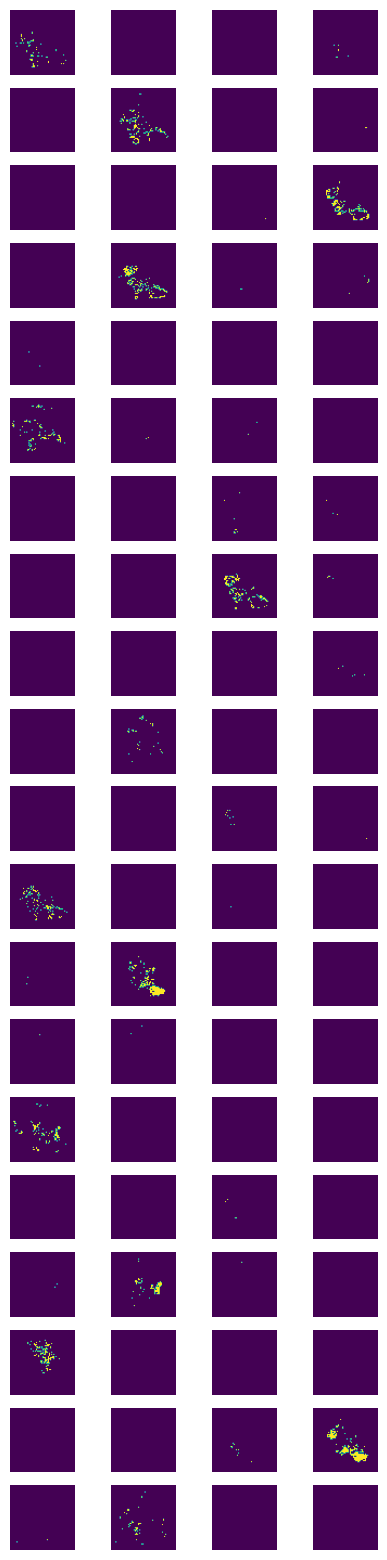

In [546]:
clusters = exp_df.sort_values('CD45', ascending=False).index.to_list()[:20]
fig, axs = plt.subplots(nrows=len(clusters), ncols=cluster_ids.shape[0], figsize=(5, 20))
for i, cluster in enumerate(clusters):
    print(cluster, exp_df.loc[cluster, 'CD45'])
    for j in range(cluster_ids.shape[0]):
        ax = axs[i, j]
#         ax.imshow(exp[j, mushroom.learner.channels.index('CD31')])
        ax.imshow(cluster_ids[j]==cluster)
        ax.axis('off')

2 1.0
82 1.0
91 0.8723408
67 0.82530147
21 0.7111688
26 0.71077937
12 0.70496607
75 0.7047534
18 0.6684132
63 0.63384736
43 0.6248026
49 0.61403656
29 0.54966056
32 0.4663092
86 0.44753796
64 0.44225764
59 0.40401056
34 0.30382702
35 0.3018105
23 0.2919126


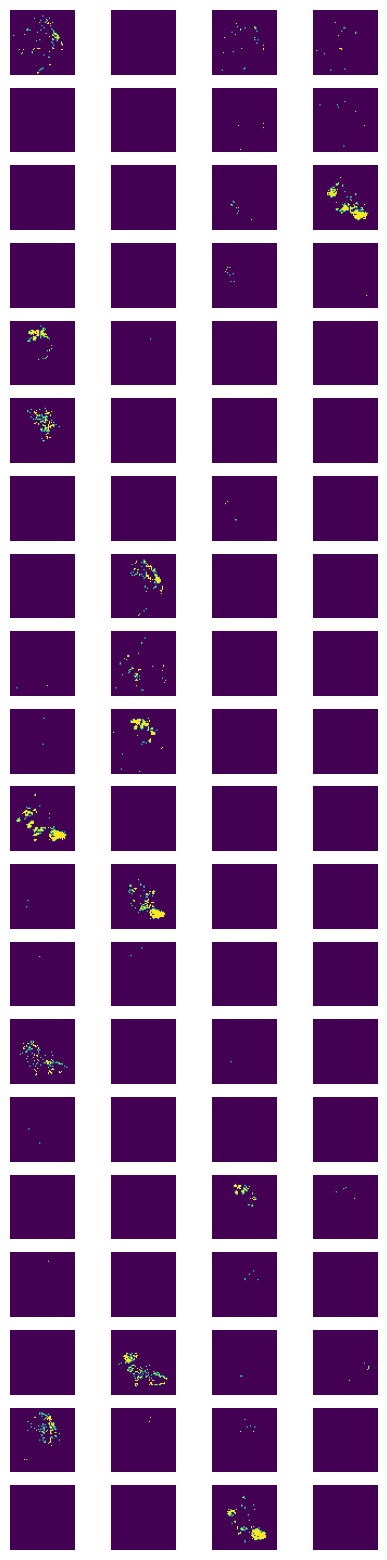

In [557]:
clusters = exp_df.sort_values('Pan-Cytokeratin', ascending=False).index.to_list()[:20]
fig, axs = plt.subplots(nrows=len(clusters), ncols=cluster_ids.shape[0], figsize=(5, 20))
for i, cluster in enumerate(clusters):
    print(cluster, exp_df.loc[cluster, 'Pan-Cytokeratin'])
    for j in range(cluster_ids.shape[0]):
        ax = axs[i, j]
#         ax.imshow(exp[j, mushroom.learner.channels.index('CD31')])
        ax.imshow(cluster_ids[j]==cluster)
        ax.axis('off')

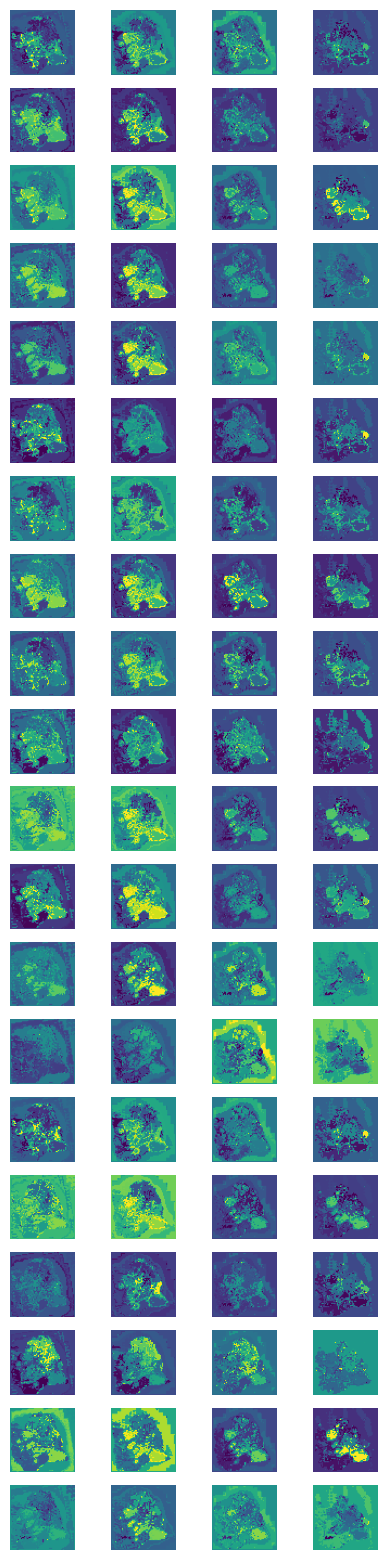

In [547]:
clusters = exp_df.sort_values('CD45', ascending=False).index.to_list()[:20]
fig, axs = plt.subplots(nrows=len(clusters), ncols=cluster_ids.shape[0], figsize=(5, 20))
for i, cluster in enumerate(clusters):
    for j in range(cluster_ids.shape[0]):
        ax = axs[i, j]
#         ax.imshow(exp[j, mushroom.learner.channels.index('CD31')])
#         ax.imshow(cluster_ids[j]==cluster)
        ax.imshow(dists[j, ..., cluster])
        ax.axis('off')

In [562]:
# cluster based on cos emb

from sklearn.cluster import AgglomerativeClustering
dist = 3.5
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=dist).fit(
    exp_df.values
)
# clustering = AgglomerativeClustering(n_clusters=10, distance_threshold=None).fit(exp.values)
cluster_to_label = {c:l for c, l in zip(exp_df.index.to_list(), clustering.labels_)}
neigh_ids = np.vectorize(cluster_to_label.get)(cluster_ids)
len(np.unique(neigh_ids))

9

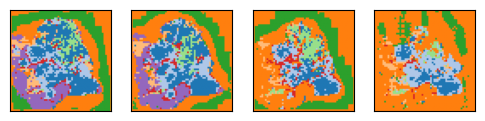

In [563]:
fig, axs = plt.subplots(ncols=neigh_ids.shape[0], figsize=(6, 4))
for i, labeled in enumerate(neigh_ids):
    axs[i].imshow(display_labeled_as_rgb(labeled, cmap=cmap))
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [565]:
distances.shape

torch.Size([4, 100, 60, 60])

In [ ]:
# cluster based on cos emb

from sklearn.cluster import AgglomerativeClustering
dist = 3.5
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=dist).fit(
    exp_df.values
)
# clustering = AgglomerativeClustering(n_clusters=10, distance_threshold=None).fit(exp.values)
cluster_to_label = {c:l for c, l in zip(exp_df.index.to_list(), clustering.labels_)}
neigh_ids = np.vectorize(cluster_to_label.get)(cluster_ids)
len(np.unique(neigh_ids))

In [69]:
counts = Counter(cluster_ids.flatten())

In [70]:
[counts[c] for c in clusters]

[17, 9, 6, 95, 99]

In [73]:
cluster_ids.shape

(4, 60, 60)

In [52]:
F.cosine_similarity(
    torch.rand(256),
    torch.rand(20, 256)
).shape

torch.Size([20])

In [48]:
F.cosine_similarity(x[...], codebook, dim=-1)

RuntimeError: The size of tensor a (60) must match the size of tensor b (40) at non-singleton dimension 2

In [39]:
import torch.nn.functional as F

In [45]:
x[n, h, w].shape, codebook[c].shape

(torch.Size([256]), torch.Size([256]))

In [ ]:
F.cosine_similarity()

In [67]:
mushroom.learner.sae.scale_factors(torch.tensor([0, 1, 2, 3]))[:, mushroom.learner.channels.index('CD45')]

tensor([ 1.6012, -0.7417,  2.3597,  0.6643], grad_fn=<SelectBackward0>)

In [152]:
ds = mushroom.learner.inference_ds

imgs = []
for idx in range(len(ds)):
    section_idx, row_idx, col_idx = ds.idx_to_coord[idx]
    section = ds.sections[section_idx]
    img = ds.section_to_tiles[section][row_idx, col_idx]
    imgs.append(img)
imgs = torch.stack(imgs)

recon_labeled = torch.stack(
    [ds.section_from_tiles(
        imgs, i,
#         size=(mushroom.learner.train_transform.output_size[0], mushroom.learner.train_transform.output_size[1])
    ) for i in range(len(ds.sections))]
)

In [153]:
with torch.no_grad():
    h, w = mushroom.recon_embs.shape[-2], mushroom.recon_embs.shape[-1]
    _, indices, _ = mushroom.learner.sae.vq(
        rearrange(mushroom.recon_embs.to(mushroom.learner.device), 'n d h w -> n (h w) d'))
    indices = rearrange(indices, 'n (h w) -> n h w', h=h, w=w).detach().cpu().numpy()

In [154]:
indices.shape

(4, 60, 60)

In [155]:
def relabel(labels):
    new = np.zeros_like(labels, dtype=labels.dtype)
    ids = np.unique(labels)
    for i in range(len(ids)):
        new[labels==ids[i]] = i
        
    return new

cluster_ids = relabel(indices)
cluster_ids.shape

(4, 60, 60)

In [156]:
np.unique(cluster_ids)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [157]:
import torchvision.transforms.functional as TF
patch_size = 32
resized_cluster_ids = TF.resize(
    torch.tensor(cluster_ids),
    (recon_labeled.shape[-2], recon_labeled.shape[-1]),
    antialias=False,
    interpolation=TF.InterpolationMode.NEAREST
).numpy()
resized_cluster_ids.shape

(4, 1920, 1920)

In [158]:
exp = []
ids = np.unique(cluster_ids)
for i in ids:
#     mask = cluster_ids == int(i)
    mask = resized_cluster_ids == int(i)
#     x = rearrange(mushroom.recon_imgs, 'n d h w -> d n h w')
    x = rearrange(mushroom.true_imgs, 'n d h w -> d n h w')
    exp.append(x[:, mask].mean(-1))

    
exp = torch.stack(exp)
exp = pd.DataFrame(data=exp.numpy(), columns=mushroom.learner.channels, index=ids)
exp = exp[~pd.isnull(exp.iloc[:, 0])]
exp


,Bap1,CD31,CD45,CD68,CD8,CK14,CK19,COX6c,DAPI,ER,...,Her2,Ki67,MGP,PLAT/tPA,PR,Pan-Cytokeratin,Podoplanin,SMA,Vimentin,cKit
0,0.135653,0.060309,0.196396,0.084181,0.013518,0.598725,0.195443,0.215644,0.444009,0.125297,...,0.095422,0.034396,0.549867,0.322370,0.230392,0.335231,0.052833,0.265551,0.286387,0.300481
1,0.102662,0.173230,0.313449,0.315419,0.014049,0.274893,0.272267,0.569661,0.479456,0.263666,...,0.165185,0.061895,0.556276,0.542538,0.306345,0.359909,0.240782,0.338380,0.344366,0.243293
2,0.214952,0.086508,0.438146,0.121400,0.039791,0.314652,0.387735,0.349714,0.633796,0.299786,...,0.233972,0.081543,0.602326,0.489407,0.410037,0.528037,0.050058,0.116576,0.319623,0.362398
3,0.022327,0.032272,0.055813,0.011232,0.013195,0.341353,0.022897,0.041572,0.203219,0.020234,...,0.015059,0.007722,0.209161,0.082997,0.137239,0.045026,0.040476,0.085965,0.160596,0.086382
4,0.256484,0.110080,0.410596,0.186311,0.034289,0.079270,0.329909,0.281702,0.535213,0.108658,...,0.121026,0.072120,0.468117,0.402524,0.285144,0.390914,0.034853,0.217675,0.285680,0.142077
5,0.038013,0.337285,0.320056,0.039905,0.052600,0.031877,0.009616,0.107503,0.552326,0.149213,...,0.063098,0.008852,0.479800,0.413995,0.210459,0.028443,0.123138,0.179513,0.679011,0.028706
6,0.062572,0.164464,0.509942,0.090697,0.132576,0.128912,0.083346,0.265080,0.551418,0.270902,...,0.073928,0.034386,0.338568,0.324116,0.215226,0.105915,0.217390,0.163324,0.496575,0.048772
7,0.002854,0.005045,0.006762,0.012790,0.005507,0.017818,0.002802,0.011778,0.075780,0.002625,...,0.002390,0.001510,0.070056,0.028942,0.026011,0.004326,0.022011,0.006881,0.032040,0.024085
8,0.357306,0.083924,0.494554,0.279103,0.035373,0.468541,0.601380,0.455954,0.726510,0.435172,...,0.390400,0.082502,0.756228,0.668009,0.514317,0.757924,0.064142,0.126356,0.212150,0.549721
9,0.179852,0.127740,0.350419,0.140682,0.016917,0.665297,0.227919,0.333807,0.438176,0.237972,...,0.152382,0.065271,0.572133,0.497277,0.307379,0.330070,0.350288,0.519348,0.472404,0.241629


In [159]:
from mushroom.visualization.utils import display_labeled_as_rgb

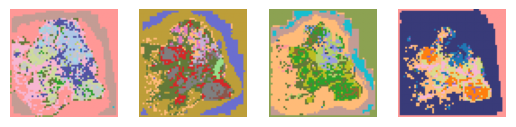

In [160]:
cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c') + sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
fig, axs = plt.subplots(ncols=len(ds.sections))
for ax, x in zip(axs, cluster_ids):
    x = display_labeled_as_rgb(x, cmap=cmap)
    ax.imshow(x)
    ax.axis('off')

In [77]:
np.unique(cluster_ids, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([ 216,  331,   32,  130,  206,  593,   99,  127, 3043,  792, 2913,
         191, 1452,  125,  644,   13,   61,   48,  522,   44,  164,  177,
           7,   18,  214,   17,  123,   13, 2079,    6]))

In [78]:

from sklearn.cluster import AgglomerativeClustering
dist = 50.
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=dist).fit(exp.values)
# clustering = AgglomerativeClustering(n_clusters=10, distance_threshold=None).fit(exp.values)
cluster_to_label = {c:l for c, l in zip(exp.index, clustering.labels_)}
neigh_ids = np.vectorize(cluster_to_label.get)(cluster_ids)
len(np.unique(neigh_ids))

13

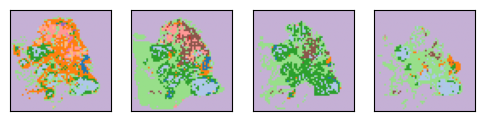

In [79]:
fig, axs = plt.subplots(ncols=neigh_ids.shape[0], figsize=(6, 4))
for i, labeled in enumerate(neigh_ids):
    axs[i].imshow(display_labeled_as_rgb(labeled, cmap=cmap))
    axs[i].set_xticks([])
    axs[i].set_yticks([])

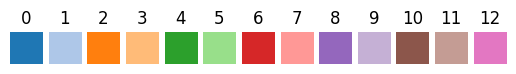

In [80]:
labels = np.unique(neigh_ids)
fig, axs = plt.subplots(ncols=len(labels))
for n, l in enumerate(labels):
    axs[n].imshow(rearrange(np.asarray(cmap[l]), 'n -> 1 1 n'))
    axs[n].axis('off')
    axs[n].set_title(str(l))
    

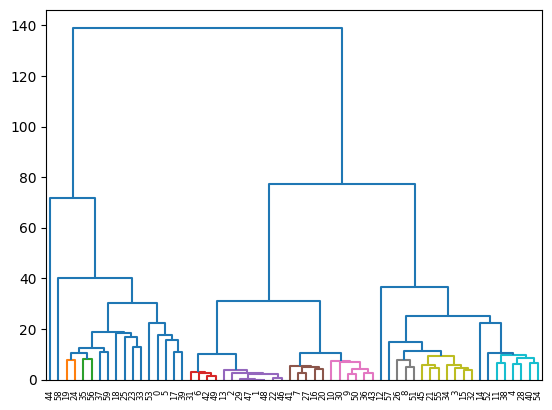

In [150]:
import scipy.cluster.hierarchy as shc
links = shc.linkage(exp.values, method ='ward')
dendrogram = shc.dendrogram((links), color_threshold=dist, labels=exp.index.to_list())

In [581]:
pred_pixel_values = torch.rand(128, 64, 24)
patches = torch.rand(128, 64, 24)


In [582]:
num_patches = 8
grid_pixel_values = rearrange(pred_pixel_values, 'b (h w) c -> b h w c', h=num_patches, w=num_patches)
grid_patches = rearrange(patches, 'b (h w) c -> b h w c', h=num_patches, w=num_patches)
grid_pixel_values.shape

torch.Size([128, 8, 8, 24])

In [579]:
TF.gaussian_blur(grid_pixel_values, kernel_size=3).shape

torch.Size([32, 8, 8, 100])

In [448]:
F.cosine_similarity(pred_pixel_values, patches) # (b, n, channels)

tensor([[0.7302, 0.7093, 0.7423,  ..., 0.8095, 0.7714, 0.6906],
        [0.7535, 0.6986, 0.6747,  ..., 0.7694, 0.7759, 0.7477],
        [0.7388, 0.7439, 0.7433,  ..., 0.7754, 0.7432, 0.7767],
        ...,
        [0.8206, 0.6784, 0.8090,  ..., 0.7690, 0.7773, 0.7695],
        [0.7926, 0.7725, 0.7419,  ..., 0.7613, 0.7216, 0.7341],
        [0.7841, 0.7534, 0.7337,  ..., 0.7349, 0.8396, 0.7394]])

In [449]:
F.cosine_similarity(pred_pixel_values, patches).shape

torch.Size([32, 100])

In [451]:
F.cosine_embedding_loss(pred_pixel_values, patches, torch.ones(pred_pixel_values.shape[0], device=pred_pixel_values.device))


tensor(0.2548)